In [ ]:
# Imports.
import numpy as np
import tensorflow as tf
import os, glob
from PIL import Image
from tensorflow.keras.regularizers import l2
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten

In [ ]:
# GPU Info.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Nov 24 02:29:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Directory
local_dir = os.getcwd() + "/drive/My Drive/MA305_Project"
dataset_dir = local_dir + "/Dataset"
train_dir = dataset_dir + "/temp_train"
validation_dir = dataset_dir + '/temp_val'

In [ ]:
os.listdir(validation_dir)

['Bicycle', 'Motorcycle', 'Truck', 'Horse', 'Dog']

In [ ]:
# Data gens.
training_datagen =  ImageDataGenerator(
			rescale = 1./255,
      rotation_range=60,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(224, 224),
	class_mode='categorical',
  batch_size=10)
validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=(224, 224),
	class_mode='categorical',
  batch_size=10)


Found 13250 images belonging to 5 classes.
Found 728 images belonging to 5 classes.


In [ ]:
# Neural Network.
lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

from tensorflow import keras
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,
                       filters_5x5_reduce, filters_5x5, filters_pool_proj,
                       name=None):

  conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

  conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

  conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

  output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

  return output

def inception_model(input_shape):
  input_layer  = Input(shape=input_shape)
  x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
  x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
  x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

  x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

  x = inception_module(x,
                      filters_1x1=128,
                      filters_3x3_reduce=128,
                      filters_3x3=192,
                      filters_5x5_reduce=32,
                      filters_5x5=96,
                      filters_pool_proj=64,
                      name='inception_3b')

  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

  x = inception_module(x,
                      filters_1x1=192,
                      filters_3x3_reduce=96,
                      filters_3x3=208,
                      filters_5x5_reduce=16,
                      filters_5x5=48,
                      filters_pool_proj=64,
                      name='inception_4a')


  x1 = AveragePooling2D((5, 5), strides=3)(x)
  x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
  x1 = Flatten()(x1)
  x1 = Dense(1024, activation='relu')(x1)
  x1 = Dropout(0.7)(x1)
  x1 = Dense(5, activation='softmax', name='auxilliary_output_1')(x1)

  x = inception_module(x,
                      filters_1x1=160,
                      filters_3x3_reduce=112,
                      filters_3x3=224,
                      filters_5x5_reduce=24,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4b')

  x = inception_module(x,
                      filters_1x1=128,
                      filters_3x3_reduce=128,
                      filters_3x3=256,
                      filters_5x5_reduce=24,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4c')

  x = inception_module(x,
                      filters_1x1=112,
                      filters_3x3_reduce=144,
                      filters_3x3=288,
                      filters_5x5_reduce=32,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4d')


  x2 = AveragePooling2D((5, 5), strides=3)(x)
  x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
  x2 = Flatten()(x2)
  x2 = Dense(1024, activation='relu')(x2)
  x2 = Dropout(0.7)(x2)
  x2 = Dense(5, activation='softmax', name='auxilliary_output_2')(x2)

  x = inception_module(x,
                      filters_1x1=256,
                      filters_3x3_reduce=160,
                      filters_3x3=320,
                      filters_5x5_reduce=32,
                      filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_4e')

  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

  x = inception_module(x,
                      filters_1x1=256,
                      filters_3x3_reduce=160,
                      filters_3x3=320,
                      filters_5x5_reduce=32,
                      filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_5a')

  x = inception_module(x,
                      filters_1x1=384,
                      filters_3x3_reduce=192,
                      filters_3x3=384,
                      filters_5x5_reduce=48,
                      filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_5b')

  x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

  x = Dropout(0.4)(x)

  x = Dense(5, activation='softmax', name='output')(x)
  return Model(input_layer, [x, x1, x2], name='inception_v1')


input_shape = (224, 224, 3)
model = inception_model(input_shape)
model.summary()


Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [ ]:
# Edit model.
model.load_weights(os.getcwd() + "/drive/My Drive/MA305_Project/best_weights_inception_5_classes.h5")
# model.load_weights("best_weights_le_net_5.h5")
#output = Dense(2, activation='softmax')(model.layers[-2].output)
##model = Model(inputs=model.input, outputs=[output])
#model.summary()

In [ ]:
# Model compilation and fit.
from keras.callbacks import ModelCheckpoint 
checkpoint = ModelCheckpoint('best_weights_inception_5_classes.h5', 
                                 verbose=1, monitor='loss', 
                                 save_best_only=True, mode='auto')
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
#model.compile(loss ='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
#history = model.fit(train_generator, validation_data = validation_generator, 
#                    epochs=50, batch_size = 10, callbacks=[checkpoint])

In [ ]:
import matplotlib.pyplot as plt

labels = validation_generator.class_indices
labels = dict([(value, key) for key, value in labels.items()]) 
test_classes = ['Bicycle', 'Dog', 'Horse', 'Motorcycle', 'Truck']

for test_class in test_classes:

  cur_dir = train_dir + '//' + test_class + '//'
  class_files = os.listdir(train_dir + '//' + test_class)
  print('\n Class:', test_class, len(class_files))

  accuracies = []
  for i in range(0, 400):

    img_dir = cur_dir + class_files[i]
    pil_image = tf.keras.preprocessing.image.load_img(img_dir, target_size=(224, 224))

    test_image = tf.keras.preprocessing.image.img_to_array(pil_image)   # Numpy array with shape (224, 224, 3)
    test_image = test_image.reshape((1,) + test_image.shape)     # Numpy array with shape (1, 224, 224, 3)
    test_image /= 255.0   # Rescale by 1/255

    results = model.predict(test_image)
    results_array = np.asarray([r[0] for r in results])
    scores = np.mean(results_array, axis=0)
    score = 100*scores[idx]
    idx = np.argmax(scores)
    label = labels[idx]

    if label == test_class:
      accuracies.append(score)

    #if score > 90:
    #  plt.imshow(pil_image)
    #  plt.show()
    #  print('Image corresponds to class {} ({}),'.format(idx + 1, label))
    #  print("    with confidence of {}%.".format(round(score, 2)))
  print(len(accuracies), sum(accuracies), sum(accuracies) / len(accuracies))



 Class: Bicycle 2740
334 25513.270798548656 76.38703831900796

 Class: Dog 2735
272 14128.031801030418 51.94129338614124

 Class: Horse 2727
396 37917.32438360989 95.75081915053003

 Class: Motorcycle 2402
358 28718.283366767213 80.21866862225478

 Class: Truck 2647
325 22559.83769945441 69.41488522909049


(1e-05, 0.01, 3.4, 4.0)

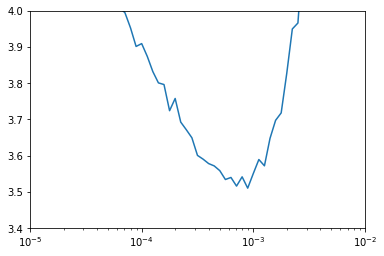

In [ ]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-2, 3.4, 4])
